# Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter
import matplotlib.ticker as ticker
from shapely.geometry import Point
import folium

# North Ridge Estates: Klamath Falls, Oregon

In [47]:
vis_dir = "../visualizations/additional/"

In [3]:
API_key = '57c26501ddcc34b05931d602c9bde30020f36ab4'

all_data = []

for year in np.arange(2013, 2024):
    url = f'https://api.census.gov/data/{year}/acs/acs5'
    params = {
        'get': 'NAME,B19013_001E',
        'for': 'place:*',
        'in': 'state:41',
        'key': API_key}
    response = requests.get(url, params=params)
    response = requests.get(url, params=params)
    data = response.json()
    df = pd.DataFrame(data[1:], columns = data[0])
    df['year'] = year
    all_data.append(df)

acs_df = pd.concat(all_data, ignore_index = True)
acs_df.tail()

,NAME,B19013_001E,state,place,year
4342,"Woodburn city, Oregon",67469,41,83750,2023
4343,"Wood Village city, Oregon",72404,41,83950,2023
4344,"Yachats city, Oregon",70000,41,84200,2023
4345,"Yamhill city, Oregon",121250,41,84250,2023
4346,"Yoncalla city, Oregon",55000,41,84600,2023


## Data Cleaning

In [4]:
#Im renaming the column name to median household income in the past 12months
median_household = acs_df.rename(columns = {'B19013_001E':'Median Household Income'})
median_household.head(5)

#Im turning median income into integers since they're strings
median_household['Median Household Income'] = pd.to_numeric(median_household['Median Household Income'], errors ='coerce')
median_household['year'] = pd.to_numeric(median_household['year'], errors ='coerce')

#getting rid of na values or negative values
invalid_count = (median_household['Median Household Income'] <= 0).sum()
total_count = len(median_household)
print(f"Invalid values: {invalid_count} ({invalid_count / total_count:.2%} of total)")

median_household = median_household[median_household['Median Household Income'] > 0]

#grouping by year to get avg income over time (Hermiston city)
median_household_herm = median_household[median_household['NAME'] == 'Hermiston city, Oregon']
grouped_herm = median_household_herm

#grouping by year to get avg income over time (Klamath Falls-near site)
median_household_kla = median_household[median_household['NAME'] == 'Klamath Falls city, Oregon']
grouped_kla = median_household_kla

Invalid values: 346 (7.96% of total)


## Run the next code cell to plot a time series

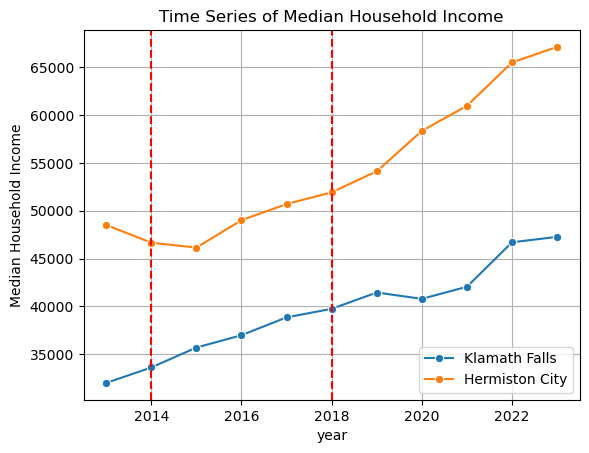

In [58]:
sns.lineplot(data = grouped_kla, x = 'year', y = 'Median Household Income', marker = 'o', label = 'Klamath Falls')
sns.lineplot(data = grouped_herm, x = 'year', y = 'Median Household Income', marker = 'o', label = 'Hermiston City')

plt.title('Time Series of Median Household Income')
plt.legend()
plt.grid(True)
plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig(vis_dir + "median_household_income_ts_klamath.jpg", dpi=300)

## Now lets create another DF with ethnicities

In [7]:
#iterates through ac5 data,

ethnicity_data = []

for year in np.arange(2013, 2024):
    url = f'https://api.census.gov/data/{year}/acs/acs5'
    params1 = {
        'get': 'NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E',
        'for': 'place:*',
        'in': 'state:41',
        'key': API_key}

    response1 = requests.get(url, params=params1)
    data1 = response1.json()
    df1 = pd.DataFrame(data1[1:], columns = data1[0])
    df1['year'] = year
    ethnicity_data.append(df1)

ethnicity_df = pd.concat(ethnicity_data, ignore_index = True)
ethnicity_df.tail()

,NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E,state,place,year
4342,"Woodburn city, Oregon",26845,16813,13209,84,241,41,83750,2023
4343,"Wood Village city, Oregon",4611,2299,2513,28,89,41,83950,2023
4344,"Yachats city, Oregon",881,34,801,5,1,41,84200,2023
4345,"Yamhill city, Oregon",1179,114,1068,0,50,41,84250,2023
4346,"Yoncalla city, Oregon",1106,40,973,0,3,41,84600,2023


## Data Cleaning

In [8]:
ethnicity_df = ethnicity_df.rename(columns ={
    'B03001_001E': 'Total_Pop',
    'B03003_003E': 'Hispanic_or_Latino',
    'B02001_002E': 'White_alone',
    'B02001_003E': 'Black_alone',
    'B02001_005E': 'Asian_alone'
})

eth_column = ['Total_Pop','Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']
for i in eth_column:
    if i in ethnicity_df.columns:
        ethnicity_df[i] = pd.to_numeric(ethnicity_df[i], errors ='coerce')

Klamath_falls_ethnicity = ethnicity_df[ethnicity_df['NAME'] == 'Klamath Falls city, Oregon']
Klamath_falls_ethnicity.head(5)

,NAME,Total_Pop,Hispanic_or_Latino,White_alone,Black_alone,Asian_alone,state,place,year
96,"Klamath Falls city, Oregon",21026,2811,17864,218,427,41,39700,2013
712,"Klamath Falls city, Oregon",21165,2512,18006,311,339,41,39700,2014
903,"Klamath Falls city, Oregon",21261,2852,18217,301,312,41,39700,2015
1406,"Klamath Falls city, Oregon",21322,2971,18369,275,201,41,39700,2016
1577,"Klamath Falls city, Oregon",21113,2790,18039,394,213,41,39700,2017


## Plotting a time series of population by ethnicity

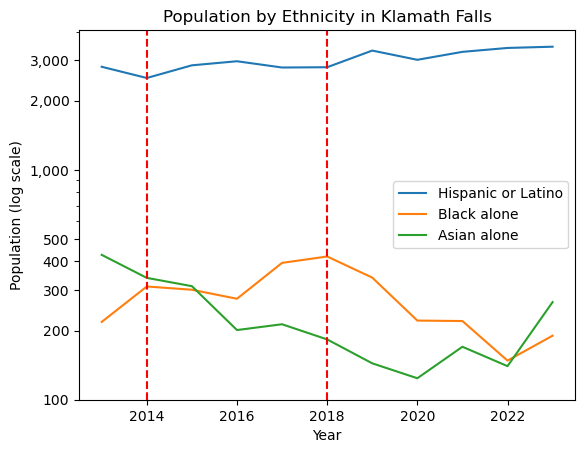

In [39]:
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Hispanic_or_Latino',label='Hispanic or Latino')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Black_alone', label='Black alone')
sns.lineplot(data=Klamath_falls_ethnicity, x='year', y='Asian_alone', label='Asian alone')

ax = plt.gca()

plt.title('Population by Ethnicity in Klamath Falls')
plt.ylabel('Population (log scale)')
plt.xlabel('Year')
plt.legend()
plt.yscale('log')

plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')

ax.set_yticks([100, 200, 300, 400, 500, 1000, 2000, 3000])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.savefig(vis_dir + "pop_by_eth_klamath.jpg", dpi=300)

In [10]:
hermiston_city_ethnicity = ethnicity_df[ethnicity_df['NAME'] == "Hermiston city, Oregon"]
hermiston_city_ethnicity = hermiston_city_ethnicity.melt(id_vars="year", value_vars=["Hispanic_or_Latino", "Black_alone", "Asian_alone"])
hermiston_city_ethnicity.head()

,year,variable,value
0,2013,Hispanic_or_Latino,5508
1,2014,Hispanic_or_Latino,5606
2,2015,Hispanic_or_Latino,5696
3,2016,Hispanic_or_Latino,6114
4,2017,Hispanic_or_Latino,6335


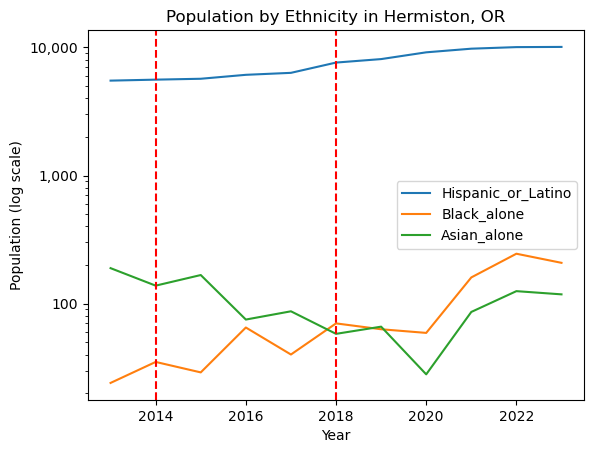

In [40]:
sns.lineplot(data=hermiston_city_ethnicity, x='year', y='value', hue='variable', legend="full")
plt.title('Population by Ethnicity in Hermiston, OR')
plt.ylabel('Population (log scale)')
plt.xlabel('Year')
plt.legend()
plt.yscale('log')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.axvline(x=2014, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2018, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.savefig(vis_dir + "pop_by_eth_hermiston.jpg", dpi=300)

# River City Metal Finishing: San Antonio, Texas

## Coordinates for Sites

In [41]:
state_fips = "48"

acs_year = 2023

lon = -98.73187
lat = 29.43049

### Getting Census tracts

In [42]:
tracts_gdf = gpd.read_file(
    f"https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_48_tract.zip"
) 

tracts_tx = tracts_gdf[tracts_gdf["STATEFP"] == "48"]

tracts_bexar = tracts_tx[tracts_tx["COUNTYFP"] == "029"].copy()

## Fetching data from ACS

In [43]:
url = f"https://api.census.gov/data/{acs_year}/acs/acs5"

params = {
    "get": "B19013_001E,B25077_001E,B25064_001E,NAME",
    "for": "tract:*",
    "in": f"state:{state_fips}",
    "key": API_key
}

r = requests.get(url, params=params)
data = r.json()

acs_df = pd.DataFrame(data[1:], columns=data[0])

## Data Cleaning

In [44]:
acs_df = acs_df.rename(columns={
    "B19013_001E" : "median_income",
    "B25077_001E": "median_home_value",
    "B25064_001E": "median_rent"
})

acs_df["median_home_value"] = pd.to_numeric(acs_df["median_home_value"], errors="coerce")
acs_df["median_rent"] = pd.to_numeric(acs_df["median_rent"], errors="coerce")

acs_df.loc[acs_df["median_home_value"] > 1_000_000, "median_home_value"] = np.nan
acs_df.loc[acs_df["median_rent"] > 10_000, "median_rent"] = np.nan

acs_df["GEOID"] = acs_df["state"] + acs_df["county"] + acs_df["tract"]

## Merge

In [45]:
tracts_bexar["GEOID"] = tracts_bexar["STATEFP"] + tracts_bexar["COUNTYFP"] + tracts_bexar["TRACTCE"]
tracts_bexar = tracts_bexar.merge(acs_df, on="GEOID", how="left")

In [73]:
bins = [0, 100000, 150000, 200000, 250000, 300000, np.inf]
labels = [
    "<100k",
    "100k–150k",
    "150k–200k",
    "200k–250k",
    "250k–300k",
    "300k+"
]

m = folium.Map(location=[29.4241, -98.70], zoom_start=12)

tracts_bexar["value_bin"] = pd.cut(
    tracts_bexar["median_home_value"],
    bins=bins,
    labels=labels,
    include_lowest=True
)


tracts_bexar.explore(
    m = m,
    column="value_bin",
    categorical=True,
    cmap="YlOrRd",
    legend=True,
    legend_kwds={"title": "Median Home Value"},
)

## Adding in another layer

In [74]:
site = gpd.GeoDataFrame(
    {"Site": ["River City Metal Finishing"]},
    geometry=gpd.points_from_xy([-98.731875], [29.430489]),
    crs="EPSG:4326"
)

site.explore(
    m=m,
    color="blue",
    marker_kwds={"radius": 8},
    tooltip=["Site"]
)

m
m.save(vis_dir + "bexar_county_median_home_value_2023_folio.html")

## Create new dataframe but with Texas data

In [28]:
time = range(2011, 2023)
all_tract_data = []

for year in time:
  url = f"https://api.census.gov/data/{year}/acs/acs5"

  params = {
    "get": "B19013_001E,NAME",
    "for": "tract:*",
    "in": f"state:{state_fips}",
    "key": API_key
}

  r = requests.get(url, params=params)
  data = r.json()

  df_temp = pd.DataFrame(data[1:], columns=data[0])
  df_temp['median_income'] = pd.to_numeric(df_temp['B19013_001E'], errors='coerce')
  df_temp['GEOID'] = df_temp['state'] + df_temp['county'] + df_temp['tract']
  df_temp['year'] = year

  all_tract_data.append(df_temp[['GEOID', 'year', 'median_income']])

timeseries_income = pd.concat(all_tract_data, ignore_index=True)
timeseries_income

,GEOID,year,median_income
0,48201552102,2011,94704.0
1,48201552001,2011,56306.0
2,48201552101,2011,63000.0
3,48201552103,2011,63998.0
4,48201552301,2011,64565.0
...,...,...,...
68068,48505950402,2022,37827.0
68069,48507950100,2022,35132.0
68070,48507950200,2022,38063.0
68071,48507950301,2022,49861.0


## Data Cleaning

In [63]:
cleaned_income = timeseries_income[timeseries_income["median_income"] > 0]

river_city_point = gpd.GeoDataFrame(
    geometry=[Point(-98.731875, 29.430489)],
    crs="EPSG:4326"
)

river_city_point = river_city_point.to_crs(tracts_bexar.crs)

treatment_tract = gpd.sjoin(
    tracts_bexar,
    river_city_point,
    how="inner",
    predicate="contains"
)

treatment_geoid = treatment_tract.iloc[0]["GEOID"]

treatment_geometry = treatment_tract.geometry.iloc[0]
control_tract = tracts_bexar.geometry.touches(treatment_geometry)
control_tracts = tracts_bexar[control_tract]

treated_geoid = treatment_tract.iloc[0]["GEOID"]

treated_value = tracts_bexar.loc[tracts_bexar["GEOID"] == treated_geoid, "median_home_value"].values[0]

control_geoid = (
    tracts_bexar[
        tracts_bexar["GEOID"].isin([
            "48029172003",
            "48029172001",
            "48029172009",
            "48029172008",
            "48029171922",
            "48029172006",
            "48029171921",
            "48029171916",
            "48029171918",
            "48029171917",
            "48029172004"])]
    .assign(diff=lambda df: (df["median_home_value"] - treated_value).abs())
    .sort_values("diff")
    .iloc[0]["GEOID"]
)

ts_filtered = cleaned_income[cleaned_income["GEOID"].isin([treated_geoid, control_geoid])]

ts_filtered = ts_filtered.copy()


ts_filtered['GEOID'] = np.where(ts_filtered['GEOID'] == '48029172002',
                                '48029172002: River City Metal Finishing',
                                ts_filtered['GEOID'] + ': Control Tract')


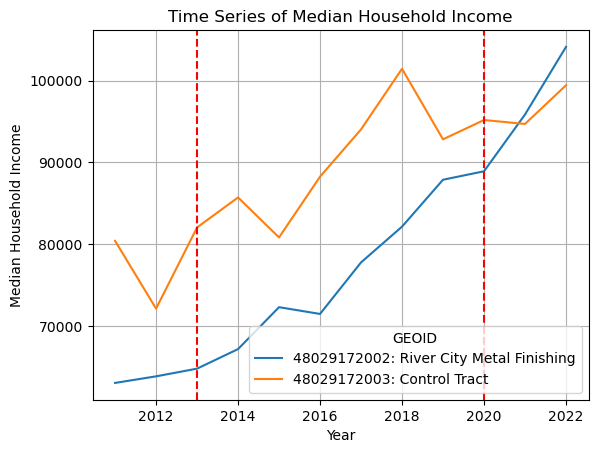

In [64]:
sns.lineplot(data = ts_filtered, x = 'year', y = 'median_income', hue = 'GEOID')
plt.axvline(x=2013, color = 'red', linestyle = '--', label = 'Remedial Action Began')
plt.axvline(x=2020, color = 'red', linestyle = '--', label = 'Cleanup Completed')
plt.title('Time Series of Median Household Income')
plt.xlabel('Year')
plt.ylabel('Median Household Income')
plt.grid()
plt.savefig(vis_dir + "ts_income_tx.png", dpi=300)

In [65]:
ethnicity_data = []

for year in np.arange(2011, 2024):
    url = f'https://api.census.gov/data/{year}/acs/acs5'
    params1 = {
        'get': 'NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E',
        'for': 'tract:*',
        "in": f"state:{state_fips}",
        'key': API_key}

    response1 = requests.get(url, params=params1)
    data1 = response1.json()
    df1 = pd.DataFrame(data1[1:], columns = data1[0])
    df1['year'] = year
    ethnicity_data.append(df1)

ethnicity_df = pd.concat(ethnicity_data, ignore_index = True)
ethnicity_df.tail()

,NAME,B03001_001E,B03003_003E,B02001_002E,B02001_003E,B02001_005E,state,county,tract,year
74964,Census Tract 9504.02; Zapata County; Texas,2141,2053,878,18,0,48,505,950402,2023
74965,Census Tract 9501; Zavala County; Texas,1033,1023,464,0,0,48,507,950100,2023
74966,Census Tract 9502; Zavala County; Texas,1166,1028,431,72,30,48,507,950200,2023
74967,Census Tract 9503.01; Zavala County; Texas,1917,1698,776,0,0,48,507,950301,2023
74968,Census Tract 9503.02; Zavala County; Texas,5416,5082,1798,7,48,48,507,950302,2023


In [66]:
ethnicity_df = ethnicity_df.rename(columns={
    'B03001_001E': 'Total_Pop',
    'B03003_003E': 'Hispanic_or_Latino',
    'B02001_002E': 'White_alone',
    'B02001_003E': 'Black_alone',
    'B02001_005E': 'Asian_alone'
})

eth_columns = ['Total_Pop','Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']

for col in eth_columns:
    if col in ethnicity_df.columns:
        ethnicity_df[col] = pd.to_numeric(ethnicity_df[col], errors='coerce')

In [67]:
ethnicity_df['GEOID'] = ethnicity_df['state'] + ethnicity_df['county'] + ethnicity_df['tract']

In [68]:
ethnicity_df = ethnicity_df.rename(columns ={
    'B03001_001E': 'Total_Pop',
    'B03003_003E': 'Hispanic_or_Latino',
    'B02001_002E': 'White_alone',
    'B02001_003E': 'Black_alone',
    'B02001_005E': 'Asian_alone'
})

eth_column = ['Total_Pop','Hispanic_or_Latino','White_alone','Black_alone','Asian_alone']
for i in eth_column:
    if i in ethnicity_df.columns:
        ethnicity_df[i] = pd.to_numeric(ethnicity_df[i], errors ='coerce')

In [69]:
treated_ethnicity = ethnicity_df[ethnicity_df['GEOID'] == treated_geoid]

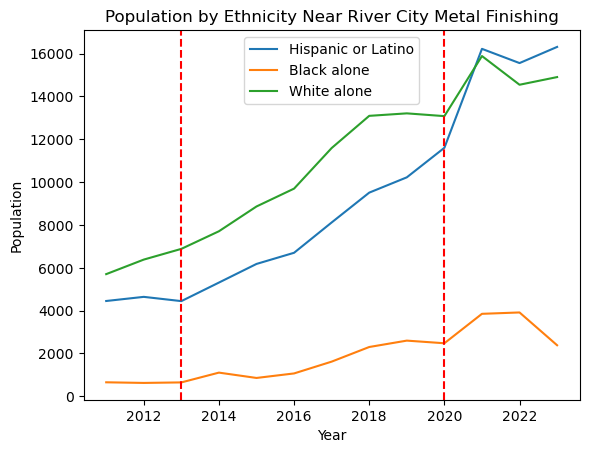

In [70]:
sns.lineplot(data = treated_ethnicity, x = 'year', y = 'Hispanic_or_Latino', label='Hispanic or Latino')
sns.lineplot(data = treated_ethnicity, x = 'year', y = 'Black_alone',  label='Black alone')
sns.lineplot(data = treated_ethnicity, x = 'year', y = 'White_alone', label='White alone')
plt.title('Population by Ethnicity Near River City Metal Finishing')
plt.axvline(x=2013, color = 'red', linestyle = '--')
plt.axvline(x=2020, color = 'red', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.savefig(vis_dir + "pop_by_eth_river.jpg", dpi=300)

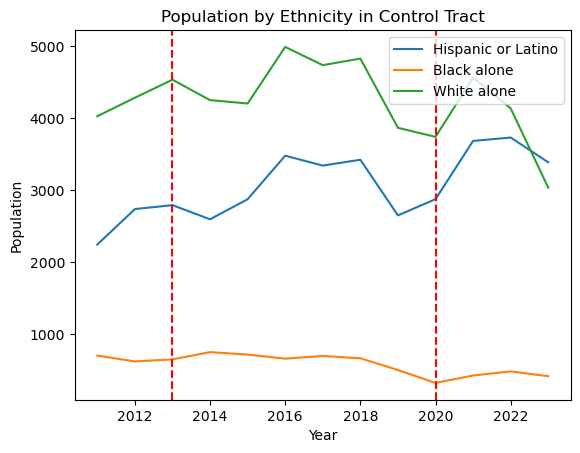

In [71]:
controlled_ethnicity = ethnicity_df[ethnicity_df['GEOID'] == control_geoid]
sns.lineplot(data = controlled_ethnicity, x = 'year', y = 'Hispanic_or_Latino', label='Hispanic or Latino')
sns.lineplot(data = controlled_ethnicity, x = 'year', y = 'Black_alone',  label='Black alone')
sns.lineplot(data = controlled_ethnicity, x = 'year', y = 'White_alone', label='White alone')
plt.axvline(x=2013, color = 'red', linestyle = '--')
plt.axvline(x=2020, color = 'red', linestyle = '--')

plt.title('Population by Ethnicity in Control Tract')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.savefig(vis_dir + "pop_by_eth_controltract.jpg", dpi=300)